Код, позволяющий подключиться ноутбуку к вашему гугл диску

In [ ]:
from google.colab import drive
drive.mount('/content/MyDrive')

Mounted at /content/MyDrive


Импорты библиотек

In [ ]:
%matplotlib inline
import matplotlib.image as mpimg
import numpy as np
import matplotlib.pyplot as plt
import os,sys
import tensorflow as tf
from PIL import Image
import scipy
import matplotlib.image as mpimg
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D, AveragePooling2D, LSTM, Concatenate
from keras.optimizers import SGD
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.core import Reshape

Вспомогательные функции, потребуются для работы с картинками

In [ ]:
def load_image(infilename):
    data = mpimg.imread(infilename)
    return data

def img_crop_padded(im, w, h, pad):
    list_patches = []
    
    imgwidth = im.shape[0] - pad
    imgheight = im.shape[1] - pad
    
    is_2d = len(im.shape) < 3
    for i in range(pad,imgheight,h):
        for j in range(pad,imgwidth,w):
            if is_2d:
                im_patch = im[j-pad:j+w+pad, i-pad:i+h+pad]
            else:
                im_patch = im[j-pad:j+w+pad, i-pad:i+h+pad, :]
            list_patches.append(im_patch)
    return list_patches

def deflatten(img_flat, patch_size):
    img = []
    for i in range(len(img_flat)):
        img.append(img_flat[i].reshape((patch_size,patch_size)))
    return img


# Function to ransform patches into a complete black and white image
def label_to_img(imgwidth, imgheight, w, h, labels):
    im = np.zeros([imgwidth, imgheight])
    idx = 0
    for i in range(0,imgheight,h):
        for j in range(0,imgwidth,w):
            im[j:j+w, i:i+h] = labels[idx]
            idx = idx + 1
    return im

def make_img_overlay(img, predicted_img):
    w = img.shape[0]
    h = img.shape[1]
    color_mask = np.zeros((w, h, 3), dtype=np.uint8)
    color_mask[:,:,0] = predicted_img*255

    img8 = img_float_to_uint8(img)
    background = Image.fromarray(img8, 'RGB').convert("RGBA")
    overlay = Image.fromarray(color_mask, 'RGB').convert("RGBA")
    new_img = Image.blend(background, overlay, 0.2)
    return new_img

def concatenate_images(img, gt_img):
    nChannels = len(gt_img.shape)
    w = gt_img.shape[0]
    h = gt_img.shape[1]
    if nChannels == 3:
        cimg = np.concatenate((img, gt_img), axis=1)
    else:
        gt_img_3c = np.zeros((w, h, 3), dtype=np.uint8)
        gt_img8 = img_float_to_uint8(gt_img)          
        gt_img_3c[:,:,0] = gt_img8
        gt_img_3c[:,:,1] = gt_img8
        gt_img_3c[:,:,2] = gt_img8
        img8 = img_float_to_uint8(img)
        cimg = np.concatenate((img8, gt_img_3c), axis=1)
    return cimg

def img_crop(im, w, h):
    list_patches = []
    imgwidth = im.shape[0]
    imgheight = im.shape[1]
    is_2d = len(im.shape) < 3
    for i in range(0,imgheight,h):
        for j in range(0,imgwidth,w):
            if is_2d:
                im_patch = im[j:j+w, i:i+h]
            else:
                im_patch = im[j:j+w, i:i+h, :]
            list_patches.append(im_patch)
    return list_patches

def img_crop_output(im, w, h):
    list_patches = []
    imgwidth = im.shape[0]
    imgheight = im.shape[1]
    is_2d = len(im.shape) < 3
    for i in range(0,imgheight,h):
        for j in range(0,imgwidth,w):
            if is_2d:
                im_patch = im[j:j+w, i:i+h].flatten() # Here we add the flatten function
            else:
                im_patch = im[j:j+w, i:i+h, :].flatten() # Here we add the flatten function
            list_patches.append(im_patch)
    return list_patches


def img_float_to_uint8(img):
    rimg = img - np.min(img)
    rimg = (rimg / np.max(rimg) * 255).round().astype(np.uint8)
    return rimg
    
import os
import numpy as np
import matplotlib.image as mpimg
import re

foreground_threshold = 0.25

def patch_to_label(patch):
    df = np.mean(patch)
    if df > foreground_threshold:
        return 1
    else:
        return 0


def mask_to_submission_strings(image_filename):
    """Reads a single image and outputs the strings that should go into the submission file"""
    img_number = int(re.search(r"\d+", image_filename).group(0))
    im = mpimg.imread(image_filename)
    patch_size = 16
    for j in range(0, im.shape[1], patch_size):
        for i in range(0, im.shape[0], patch_size):
            patch = im[i:i + patch_size, j:j + patch_size]
            label = patch_to_label(patch)
            yield("{:03d}_{}_{},{}".format(img_number, j, i, label))


def masks_to_submission(submission_filename, *image_filenames):
    """Converts images into a submission file"""
    with open(submission_filename, 'w') as f:
        f.write('id,prediction\n')
        for fn in image_filenames[0:]:
            f.writelines('{}\n'.format(s) for s in mask_to_submission_strings(fn))


Начало работы скрипта: загружаем картинки и маски

In [ ]:
# image
image_dir = "/content/MyDrive/MyDrive/data/training/images/"
files = os.listdir(image_dir)
n = 100
print("Loading " + str(n) + " images")
imgs = [load_image(image_dir + files[i]) for i in range(n)]
print(files[0])

pad = 4
print("Loading " + str(n) + " images_padded")
imgs_padded = [np.pad(load_image(image_dir + files[i]), ((pad,pad),(pad,pad),(0,0)), 'constant') for i in range(n)]
print(files[0])

# groundtruth
gt_dir = "/content/MyDrive/MyDrive/data/training/groundtruth/"
print("Loading " + str(n) + " images")
gt_imgs = [load_image(gt_dir + files[i]) for i in range(n)]
print(files[0])

Loading 100 images
satImage_095.png
Loading 100 images_padded
satImage_095.png
Loading 100 images
satImage_095.png


Пример загруженной картинки и ее маски

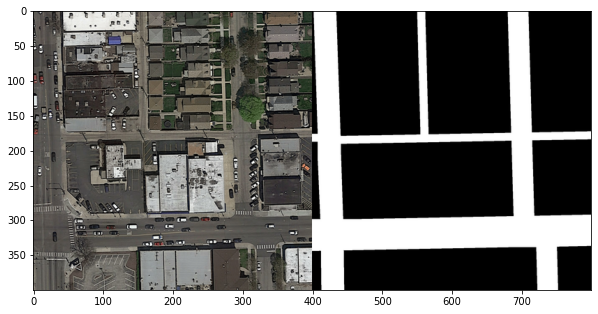

In [ ]:
cimg = concatenate_images(imgs[0], gt_imgs[0])
fig1 = plt.figure(figsize=(10, 10))
plt.imshow(cimg, cmap='Greys_r')

Преобразование картинки в массив из "патчей", 16х16 пикселей

In [ ]:
patch_size = 16
n = 100
img_patches = [img_crop_padded(imgs_padded[i], patch_size, patch_size, pad) for i in range(n)]
gt_patches = [img_crop_output(gt_imgs[i], patch_size, patch_size) for i in range(n)]
img_patches = np.asarray([img_patches[i][j] for i in range(len(img_patches)) for j in range(len(img_patches[i]))])
gt_patches =  np.asarray([gt_patches[i][j] for i in range(len(gt_patches)) for j in range(len(gt_patches[i]))])

print('Size patch image', img_patches.shape)
print('Size patch groundtruth', gt_patches.shape)

X_train = img_patches
Y_train = gt_patches

Size patch image (62500, 24, 24, 3)
Size patch groundtruth (62500, 256)


Первая ветвь нейронки

In [ ]:
model_cnn = Sequential()
model_cnn.add(Convolution2D(32, 3, 3, activation='relu', padding='same', input_shape=(24, 24, 3)))
model_cnn.add(Convolution2D(32, 3, 3, activation='relu', padding='same'))
model_cnn.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
model_cnn.add(Dropout(0.25)) 

model_cnn.add(Convolution2D(64, 3, 3, activation='relu', padding='same'))
model_cnn.add(Convolution2D(64, 3, 3, activation='relu', padding='same'))
model_cnn.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
model_cnn.add(Dropout(0.25))

model_cnn.add(Convolution2D(128, 3, 3, activation='relu', padding='same'))
model_cnn.add(Convolution2D(128, 3, 3, activation='relu', padding='same'))
model_cnn.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
model_cnn.add(Dropout(0.25))

model_cnn.add(Flatten())
model_cnn.add(Dense(1024, activation='relu'))
model_cnn.add(Dropout(0.5))

Вторая ветвь нейронки

In [ ]:

model_cnn2 = Sequential()
model_cnn2.add(Convolution2D(32, 3, 3, activation='relu', padding='same', input_shape=(24, 24, 3)))
model_cnn2.add(Convolution2D(32, 3, 3, activation='relu', padding='same'))
model_cnn2.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
model_cnn2.add(Dropout(0.25)) 

model_cnn2.add(Convolution2D(64, 3, 3, activation='relu', padding='same'))
model_cnn2.add(Convolution2D(64, 3, 3, activation='relu', padding='same'))
model_cnn2.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
model_cnn2.add(Dropout(0.25))

model_cnn2.add(Flatten())
model_cnn2.add(Dense(1024, activation='relu'))
model_cnn2.add(Dropout(0.5))

Соединяем две ветви нейронки в одну, получаем результирующую модель нейронной сети

In [ ]:
merged = Concatenate()([model_cnn2.output,model_cnn.output])
output = Dense(256, activation='sigmoid')(merged)

model_final = tf.keras.models.Model(inputs=[model_cnn2.input, model_cnn.input], outputs=[output])

Настройки компиляции модели

In [ ]:
#@title Если не необходимо рассчитывать новую модель, не выполняйте этот код
sgd = SGD(lr=0.1, decay=1e-6, momentum=0.9, nesterov=True)
model_final.compile(loss='mean_squared_error', optimizer=sgd, metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Запускаем тренировку на тренировчных данных

In [ ]:
#@title Если не необходимо рассчитывать новую модель, не выполняйте этот код
tf.config.experimental_run_functions_eagerly(True)
model_final.fit([X_train,X_train], Y_train, batch_size=32, epochs = 34)

Понравилось? Сохраняем веса в корень гугл диска

In [ ]:
#@title Если не необходимо рассчитывать новую модель, не выполняйте этот код
model_final.save_weights("/content/MyDrive/MyDrive/weight.h5")

Загрузка готовой модели

In [ ]:
model_final.load_weights("/content/MyDrive/MyDrive/weight.h5")

Ну и соответственно просмотр изображения с маской

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3704: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable.debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


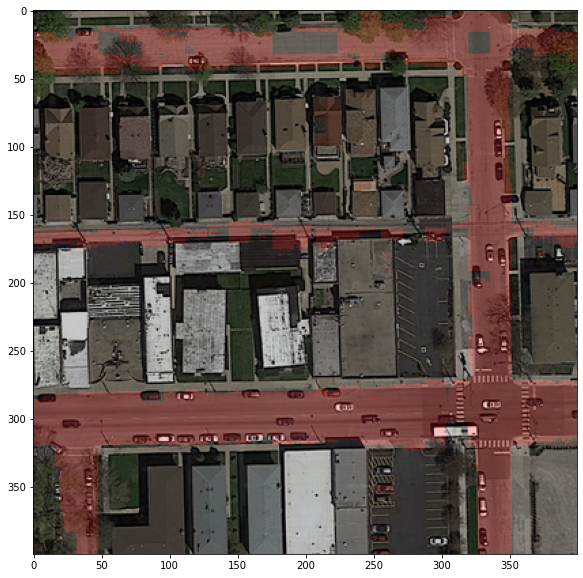

In [ ]:
img_idx = 50 #Выберите число от 1 до 50, чтобы посмотреть предсказанные маски на других тестовых картинках
X_test = np.asarray(img_crop_padded(imgs_padded[img_idx], patch_size, patch_size, pad))
prediction = model_final.predict([X_test,X_test], batch_size=32)
pred = np.array(prediction)
predict_binary = np.where(prediction > 0.5, 1, 0)
im_test = deflatten(predict_binary, patch_size)
im_non_flat = np.asarray(im_test)
w = imgs[img_idx].shape[0]
h = imgs[img_idx].shape[1]
predicted_im = label_to_img(w, h, patch_size, patch_size, im_non_flat)
new_img = make_img_overlay(imgs[img_idx], predicted_im)
fig1 = plt.figure(figsize=(10, 10))
plt.imshow(new_img)

Ну и идеальная маска, к которой стремится модель

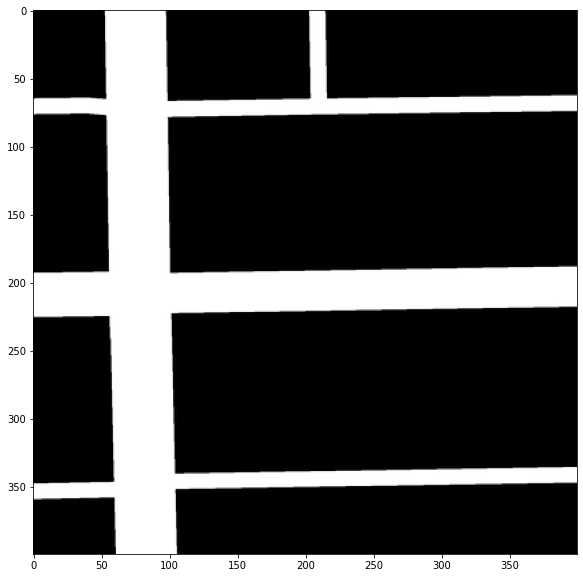

In [ ]:
fig1 = plt.figure(figsize=(10, 10))
plt.imshow(gt_imgs[img_idx], cmap='Greys_r')

In [ ]:
from keras import backend as K
def iou_coef(y_true, y_pred, smooth=1):
  intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
  union = K.sum(y_true,[1,2,3])+K.sum(y_pred,[1,2,3])-intersection
  iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
  return iou

def dice_coef(y_true, y_pred, smooth = 1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def soft_dice_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)

In [ ]:
from keras.models import Model, load_model
import tensorflow as tf
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras import optimizers
from keras.layers import BatchNormalization
from tensorflow.keras.metrics import MeanIoU
import keras

inputs = Input((IMAGE_HEIGHT, IMAGE_WIDTH, 3))
s = Lambda(lambda x: x / 255) (inputs)

conv1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (inputs)
conv1 = BatchNormalization() (conv1)
conv1 = Dropout(0.1) (conv1)
conv1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv1)
conv1 = BatchNormalization() (conv1)
pooling1 = MaxPooling2D((2, 2)) (conv1)

conv2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (pooling1)
conv2 = BatchNormalization() (conv2)
conv2 = Dropout(0.1) (conv2)
conv2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv2)
conv2 = BatchNormalization() (conv2)
pooling2 = MaxPooling2D((2, 2)) (conv2)

conv3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (pooling2)
conv3 = BatchNormalization() (conv3)
conv3 = Dropout(0.2) (conv3)
conv3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv3)
conv3 = BatchNormalization() (conv3)
pooling3 = MaxPooling2D((2, 2)) (conv3)

conv4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (pooling3)
conv4 = BatchNormalization() (conv4)
conv4 = Dropout(0.2) (conv4)
conv4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv4)
conv4 = BatchNormalization() (conv4)
pooling4 = MaxPooling2D(pool_size=(2, 2)) (conv4)

conv5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (pooling4)
conv5 = BatchNormalization() (conv5)
conv5 = Dropout(0.3) (conv5)
conv5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv5)
conv5 = BatchNormalization() (conv5)


upsample6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (conv5)
upsample6 = concatenate([upsample6, conv4])
conv6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (upsample6)
conv6 = BatchNormalization() (conv6)
conv6 = Dropout(0.2) (conv6)
conv6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv6)
conv6 = BatchNormalization() (conv6)

upsample7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (conv6)
upsample7 = concatenate([upsample7, conv3])
conv7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (upsample7)
conv7 = BatchNormalization() (conv7)
conv7 = Dropout(0.2) (conv7)
conv7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv7)
conv7 = BatchNormalization() (conv7)

upsample8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (conv7)
upsample8 = concatenate([upsample8, conv2])
conv8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (upsample8)
conv8 = BatchNormalization() (conv8)
conv8 = Dropout(0.1) (conv8)
conv8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv8)
conv8 = BatchNormalization() (conv8)

upsample9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (conv8)
upsample9 = concatenate([upsample9, conv1], axis=3)
conv9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (upsample9)
conv9 = BatchNormalization() (conv9)
conv9 = Dropout(0.1) (conv9)
conv9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv9)
conv9 = BatchNormalization() (conv9)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (conv9)

model_unet = Model(inputs=[inputs], outputs=[outputs])
model_unet.summary()

In [ ]:
opt = keras.optimizers.adam(0.0001)
model_unet.compile(
      optimizer=opt,
      loss=soft_dice_loss,
      metrics=[iou_coef])

history = model_unet.fit(train_images,
                    train_masks/255,
                    validation_split = 0.1,
                    epochs=EPOCHS,
                    batch_size = BATCH_SIZE,
                    callbacks = [checkpointer, earlystopper, lr_reducer, TensorBoardColabCallback(tbc)]
                       )

In [ ]:
ix = random.randint(0, len(predictions))
num_samples = 10

f = plt.figure(figsize = (15, 25))
for i in range(1, num_samples*4, 4):
  ix = random.randint(0, len(predictions))

  f.add_subplot(num_samples, 4, i)
  imshow(test_images[ix][:,:,0])
  plt.title("Image")
  plt.axis('off')

  f.add_subplot(num_samples, 4, i+1)
  imshow(np.squeeze(test_masks[ix][:,:,0]))
  plt.title("Groud Truth")
  plt.axis('off')

  f.add_subplot(num_samples, 4, i+2)
  imshow(np.squeeze(predictions[ix][:,:,0]))
  plt.title("Prediction")
  plt.axis('off')

  f.add_subplot(num_samples, 4, i+3)
  imshow(np.squeeze(predicton_threshold[ix][:,:,0]))
  plt.title("thresholded at {}".format(thresh_val))
  plt.axis('off')

plt.show()